# Data Generation Process
From HPC-ODA dataset we use: Cpu cycles, Instructions, Cache misses, Branch Instructions, Branch Misses and Power consumption. 

From PM100 (a dataset generated from the M100 dataset) we use: Cores Allocated, Memory Allocated, Gpu's Allocated, Time and Power Consumption.

Using relations between each of the HPC measures and the Power measure we built a percentace relation in order to then use those measure with the PM100 dataset.

### Upload HPC-ODA

In [2]:
### HPC_ODA
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns 
import matplotlib.pyplot as plt


file_path = 'C://Users/Nuno/responses.csv'


power_data = pd.read_csv('C://Users/Nuno/HPC-ODA/power_prediction/responses/responses.csv', skiprows=1, usecols=[1], header=None, names=['y'])
cache_misses_data = pd.read_csv('C://Users/Nuno/HPC-ODA/power_prediction/sensors/node0.cache-misses.csv', skiprows=1, usecols=[1], header=None, names=['y'])
branch_instructions_data = pd.read_csv('C://Users/Nuno/HPC-ODA/power_prediction/sensors/node0.branch-instructions.csv', skiprows=1, usecols=[1], header=None, names=['y']) ##These are branch instructions.
branch_misses_data = pd.read_csv('C://Users/Nuno/HPC-ODA/power_prediction/sensors/node0.branch-misses.csv', skiprows=1, usecols=[1], header=None, names=['y']) ##These are branch instructions.
cpu_cycles_data = pd.read_csv('C://Users/Nuno/HPC-ODA/power_prediction/sensors/node0.cpu-cycles.csv', skiprows=1, usecols=[1], header=None, names=['y'])
cache_misses_data = pd.read_csv('C://Users/Nuno/HPC-ODA/power_prediction/sensors/node0.cache-misses.csv', skiprows=1, usecols=[1], header=None, names=['y'])
instructions_data = pd.read_csv('C://Users/Nuno/HPC-ODA/power_prediction/sensors/node0.instructions.csv', skiprows=1, usecols=[1], header=None, names=['y']) ##These are instructions.


power = power_data['y'].values
cache_misses = cache_misses_data['y'].values
cache_misses = cache_misses[1:-1]
instructions = instructions_data['y'].values
instructions = instructions[1:-1]
cpu_cycles = cpu_cycles_data['y'].values
cpu_cycles = cpu_cycles[1:-1]
branch_instructions = branch_instructions_data['y'].values 
branch_instructions = branch_instructions[1:-1]
branch_misses = branch_misses_data['y'].values
branch_misses= branch_misses[1:-1]

instpow = np.divide(instructions,power)
cachepow = np.divide(cache_misses,power)
cpupow = np.divide(cpu_cycles,power)
brinspow = np.divide(branch_instructions,power)
brcachepow = np.divide(branch_misses,power)




### Upload PM100 (Completed only)

In [11]:
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd 

def load_data(path: str) -> pd.DataFrame:
    """Load the data from a parquet file.

    Args:
        path (str): Path to the parquet file.

    Returns:
        pd.DataFrame: Loaded DataFrame.
    """
    return pd.read_parquet(path)

if __name__ == "__main__":
    
    sns.set_theme(style="whitegrid")
    
    # Path to the PM100 data
    DATA_PATH = "C://Users/Nuno/job_table.parquet"
    
    # Load the dataframe
    df = load_data(DATA_PATH)
    
    # Filter out completed jobs
    df_completed = df[df['job_state'] == 'COMPLETED'].copy()  # Use copy() to explicitly create a copy
    
    # Exit state pie plot
    df_completed['job_state'].replace({"OUT_OF_MEMORY": "OOM+NODE FAIL", "NODE_FAIL": "OOM+NODE FAIL"}, inplace=True)

    # Plot the duration of the completed jobs divided by exit state
    # Convert runtime to minutes
    ##df_completed['run_time'] = df_completed['run_time'].apply(lambda rt: round(int(rt/60), -2))

    #df_completed['power_consumption'].to_csv('p1.csv', index=False)
    

In [3]:
def add_label (matched):
    i = 0
    for key in matched.keys():
        matched_list = matched[key]
        if len(matched_list) == 1:
            matched_list[0].append(0)
        elif len(matched_list) > 1:
            for i in range(len(matched_list)):
                matched_list[i].append(1)
                
    return (matched)

In [4]:
import random
import numpy as np

def aux(regular, irregular):
    high_bound = 0.05 * regular
    if high_bound < 2 :
        high_bound = 3
    random_values = []
    
    while sum(random_values) < regular:
        random_values.append(np.random.randint(2, high_bound))
        

    if sum(random_values) > regular:
        adjustment = sum(random_values) - regular
        while adjustment > 0:        
            max_index = random_values.index(max(random_values))
            random_values[max_index] -= 1
            adjustment -= 1
    
    array_of_ones = [1] * irregular
    
    random_values.extend(array_of_ones)
    return random_values

def add_label (matched):
    i = 0
    for key in matched.keys():
        matched_list = matched[key]
        if len(matched_list) == 1:
            matched_list[0].append(0)
        elif len(matched_list) > 1:
            for i in range(len(matched_list)):
                matched_list[i].append(1)
                
    return (matched)

import numpy as np

def generate_tuples(l, noise, num, add=None):
    matched_list = l

    for i in range(num):
        lis = [0,0,0] 
        for j in range(len(lis)):
            n = noise[j]
            low_bound = matched_list[0][j] - matched_list[0][j] * n
            high_bound = matched_list[0][j] + matched_list[0][j] * n
            to_add = round(np.random.uniform(low_bound, high_bound))
            lis[j] = to_add
        matched_list.append(lis)
    
    return matched_list

def fit(l, dist, noise):
    matched_dic = l
    dist = sorted(dist, reverse=True)
    i = 0
    keys_to_change = []
    new_matched = []
    
    keys_to_delete = []
    for key in matched_dic.keys():
        matched_list = matched_dic[key]
        if i < len(dist):
            new = dist[i] - len(matched_list)
            if new > 0:
                matched_list = generate_tuples(matched_list, noise, new)

            elif new < 0:
                keys_to_change.append(key)
                matched_list = matched_list[:new]
                new_matched.append(matched_list)
            

            else :
                matched_list = matched_list

        
        elif i >= len(dist):
            keys_to_delete.append(key)
            
        
        i = i + 1
        
    j = 0
    for key in keys_to_change:
        matched_dic[key] = new_matched[j]
        j = j + 1

    for key_to_delete in keys_to_delete:
        del matched_dic[key_to_delete]
        

    return matched_dic

def fix(matched_dic, total_values, interval, noise):
    matched = matched_dic
    lent = calc_values(matched)
        
    last_keys = list(matched.keys())[interval:]
    
    if lent > total_values:
        to_remove = lent - total_values
        keys_to_remove = random.sample(last_keys, to_remove)
        
        for key in keys_to_remove:
            del matched[key]
    else:
        while lent < total_values:
            to_add = total_values-lent
            matched = find_irr(matched,to_add,noise)
            
    return (matched)


In [5]:
import numpy as np

def generate_tuples(l, noise, num, add=None):
    matched_list = l

    for i in range(num):
        lis = [0,0,0] 
        for j in range(len(lis)):
            n = noise[j]
            low_bound = matched_list[0][j] - matched_list[0][j] * n
            high_bound = matched_list[0][j] + matched_list[0][j] * n
            to_add = round(np.random.uniform(low_bound, high_bound))
            lis[j] = to_add
        matched_list.append(lis)
    
    return matched_list
            

In [6]:
def fit(l, dist, noise):
    matched_dic = l
    dist = sorted(dist, reverse=True)
    i = 0
    keys_to_change = []
    new_matched = []
    
    keys_to_delete = []
    for key in matched_dic.keys():
        matched_list = matched_dic[key]
        if i < len(dist):
            new = dist[i] - len(matched_list)
            if new > 0:
                matched_list = generate_tuples(matched_list, noise, new)

            elif new < 0:
                keys_to_change.append(key)
                matched_list = matched_list[:new]
                new_matched.append(matched_list)
            

            else :
                matched_list = matched_list

        
        elif i >= len(dist):
            keys_to_delete.append(key)
            
        
        i = i + 1
        
    j = 0
    for key in keys_to_change:
        matched_dic[key] = new_matched[j]
        j = j + 1

    for key_to_delete in keys_to_delete:
        del matched_dic[key_to_delete]
        

    return matched_dic


In [9]:
def fix(matched_dic, total_values, interval, noise):
    matched = matched_dic
    lent = calc_values(matched)
        
    last_keys = list(matched.keys())[interval:]
    
    if lent > total_values:
        to_remove = lent - total_values
        keys_to_remove = random.sample(last_keys, to_remove)
        
        for key in keys_to_remove:
            del matched[key]
    else:
        while lent < total_values:
            to_add = total_values-lent
            matched = find_irr(matched,to_add,noise)
            
    return (matched)

In [10]:
def find_irr(matched,to_add,noise):
    instr = []
    bi = []
    tim = []
    for key in matched.keys():
        matched_list = matched[key]
        instr.append(matched_list[0][0])
        bi.append(matched_list[0][1])
        tim.append(matched_list[0][2])
    
    

In [30]:
import pandas as pd
import math
import sys


def generate_values(num_values,noise, percentage = None):
    total_values = (num_values)
    power = generate_power(total_values)
    inst = generate_instructions(total_values)
    cpucy = generate_cpu_cycles(total_values)
    cache_misses = generate_cache_misses(total_values)
    bi = generate_branch_instructions(total_values)
    bm = generate_branch_misses(total_values)
    memory = generate_memory(total_values)
    time = generate_time(total_values)
    cores = generate_cores(total_values)
    gpus = generate_gpus(total_values)
    nt = (noise/100)
    ni = np.random.uniform(0.01,nt/2)
    nbi = np.random.uniform(0.01,nt/2)
    n = [ni,nbi,nt]
    tasks = [list(t) for t in zip(inst, bi, time)]
    matched = create_dict(tasks,n)
    
    print ("DONE")
    if percentage is None:
        
        data = {
        'instructions': inst,
        'branch_instructions': bi,
        'time': time,
        #'cpu_cycles': cpucy,
        #'cache_misses': cache_misses,
        #'branch_misses': bm,
        #'memory': memory,
        #'gpus': gpus,
        #'cores': cores,
        'power': power
        }
    
        gd = pd.DataFrame(data)
        gd.to_parquet('generated_values.parquet', index=False)
        
        per_out = calc_percentage(matched)
        
    ##DATA_ADJUSTMENT:
    else:
        p = percentage
        regu = int(total_values * (percentage/100))
        irregu = int(total_values - regu)
        dist = aux(regu, irregu)

        matched= fit(matched,dist,n) ###UPDATE THE FITTING FUNCTION FOR THE DICTIONARY 
        per_out = calc_percentage(matched)
        ##matched = fix(matched, total_values,interval)
        ##per_out = calc_percentage(matched)
        
        lent = calc_values(matched)
        
        matched = add_label(matched)
        
        print (lent)
        print (matched)
        all_arrays = []
        for key, arrays in matched.items():
            for array in arrays:
                all_arrays.append(array)

        
        random.shuffle(all_arrays)
        df = pd.DataFrame(all_arrays, columns=['inst', 'bi', 'time', "label"])

        df.to_parquet('teste2.parquet', engine='pyarrow')
        ##data = {
        ##'instructions': inst,
        ##'cpu_cycles': cpucy,
        ##'cache_misses': cacmis,
        ##'branch_instructions': bi,
        ##'branch_misses': bm,
        ##'memory': memory,
        ##'gpus': gpus,
        ##'cores': cores,
        ##'time': time,
        ##'power': power
        ##}
    
        ##gd = pd.DataFrame(data)
        ##gd.to_parquet('generated_values.parquet', index=False)
    return per_out


In [31]:
print(generate_values(200000,10,50))

DONE


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



50.0


In [12]:
def create_dict(l, noise):
    check_tasks = l
    matched_dict = {}
    i = 0  # Initialize i
    n1, n2, n3 = noise  # Unpack noise values
    while i < len(check_tasks):
        matched_list = [check_tasks[i]]  # Initialize matched_list with the current index i
        value = check_tasks[i]
        indices_to_remove = []

        for j in range(i + 1, len(check_tasks)):
            if (abs(check_tasks[j][0] - value[0]) <= n1 * value[0] and
                    abs(check_tasks[j][1] - value[1]) <= n2 * value[1] and
                    abs(check_tasks[j][2] - value[2]) <= n3 * value[2]) and (i != j):
                matched_list.append(check_tasks[j])
                indices_to_remove.append(j)

        for idx in sorted(indices_to_remove, reverse=True):
            del check_tasks[idx]

        matched_dict[i] = matched_list
        i += 1

    sorted_matched_dict = {k: v for k, v in sorted(matched_dict.items(), key=lambda item: len(item[1]), reverse=True)}
    return sorted_matched_dict



In [13]:
def calc_values(matched_dic):
    lent = sum(len(matched_list) for matched_list in matched_dic.values())
    
    return lent



In [14]:
def calc_percentage (matched):
    total = 0
    reg = 0

    for key, value in matched.items():
        total += len(value)
        if len(value) > 1:
            reg += len(value)

    per = ((reg / total) * 100)
    
    return per

In [15]:
def check_percentage_individual(l, num_values, noise):
    matched = []
    i = 0  

    while i < len(l):
        matched_list = [l[i]]  
        value = l[i]
        indices_to_remove = []  
        for j in range(i + 1, len(l)):  
            if (abs(l[j] - value) <= noise * value):
                matched_list.append(l[j])
                indices_to_remove.append(j)
                
        for idx in sorted(indices_to_remove, reverse=True):
            del l[idx]
        
        if len(matched_list) > 0:
            matched.append(matched_list)  
        i += 1

    total = 0
    reg = 0

    for value in matched:
        total += len(value)
        if len(value) > 1:
            reg += len(value)
    
    per = ((reg / total) * 100)         
    
    return matched, per


### Generate Power:

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
def load_data(path: str) -> pd.DataFrame:
    """Load the data from a parquet file.

    Args:
        path (str): Path to the parquet file.

    Returns:
        pd.DataFrame: Loaded DataFrame.
    """
    return pd.read_parquet(path)

if __name__ == "__main__":
    
    sns.set_theme(style="whitegrid")

    DATA_PATH = "C://Users/Nuno/job_table.parquet"

    df = load_data(DATA_PATH)

    df_completed = df[df['job_state'] == 'COMPLETED'].copy()  # Use copy() to explicitly create a copy

    df_completed['job_state'].replace({"OUT_OF_MEMORY": "OOM+NODE FAIL", "NODE_FAIL": "OOM+NODE FAIL"}, inplace=True)


In [17]:

import pandas as pd
import math

def generate_power(num_values):
    lis = df_completed["power_consumption"]
    total_power = []

    for i in range(len(lis)):
        mean = np.mean(lis.iloc[i])
        total_power.append(mean)

    counts_pow, bin_edges_pow = np.histogram(total_power, bins='auto')

    percentages_pow = [(count / len(total_power)) * 100 for count in counts_pow]

    total_counts = num_values

    counts_pow = [(p * total_counts / 100) for p in percentages_pow]

    min_counts = [1 if count == 0 and total_counts > 0 else count for count in counts_pow]

    total_counts -= sum(counts_pow) - sum(min_counts)

    percentages_pow = [(count / sum(min_counts)) * 100 for count in min_counts]

    pow1 = []

    for count, (start, end) in zip(min_counts, zip(bin_edges_pow[:-1], bin_edges_pow[1:])):
        values = np.random.randint(start, end, math.ceil(count))
        pow1.extend(values)
    
    np.random.shuffle(pow1)


    return pow1[:num_values]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KernelDensity

def generate_power_kde(num_values, data, bandwidth=0.5):
    data = np.array(data)
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(data[:, None])
    
    new_samples = kde.sample(num_values)
    
    return new_samples.flatten()

power_data = total_power
num_values = 315000 
augmented_power_data = generate_power_kde(num_values, power_data)




### Generate relations:


In [18]:
import numpy as np
import pandas as pd
import math

def generate_instructions(num_values):
    power = pd.read_csv('C://Users/Nuno/HPC-ODA/power_prediction/responses/responses.csv', usecols=[1], header=0, names=['y'])['y'].values
    instructions = pd.read_csv('C://Users/Nuno/HPC-ODA/power_prediction/sensors/node0.instructions.csv', usecols=[1], header=0, names=['y'])['y'].values[1:-1]

    inspow = np.divide(instructions, power)

    counts_ins, bin_edges_ins = np.histogram(inspow, bins='auto')

    # Calculate percentages
    percentages_inst = [(count / len(inspow)) * 100 for count in counts_ins]

    # Calculate the counts based on the percentages
    total_counts = num_values

    counts_inst = [(p * total_counts / 100) for p in percentages_inst]

    # Ensure that each bin contributes at least one value
    min_counts = [1 if count == 0 and total_counts > 0 else count for count in counts_inst]

    # Adjust total_counts
    total_counts -= sum(counts_inst) - sum(min_counts)

    # Recalculate percentages
    percentages_inst = [(count / sum(min_counts)) * 100 for count in min_counts]

    # Generate random values based on intervals and counts
    inspow1 = []

    for count, (start, end) in zip(min_counts, zip(bin_edges_ins[:-1], bin_edges_ins[1:])):
        # Generate random values within each bin
        values = np.random.uniform(start, end, math.ceil(count))
        inspow1.extend(values)

    # Shuffle the generated values to make them random
    np.random.shuffle(inspow1)
    
    inspow1 = inspow1[:num_values]
    power = generate_power(num_values)
    inst = [round(inspow1[i] * power[i]) for i in range(num_values)]

    return inst  # Trim to the requested number of values


In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KernelDensity

def generate_kde(num_values, data, bandwidth=0.5):
    data = np.array(data)
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(data[:, None])
    
    new_samples = kde.sample(num_values)
    
    return new_samples.flatten()

num_values = 315000 
power_data = total_power
augmented_power_data = generate_kde(num_values, power_data)
augmented_instruction_data




In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import numpy as np
import pandas as pd
import math

def generate_cache_misses(num_values):
    power = pd.read_csv('C://Users/Nuno/HPC-ODA/power_prediction/responses/responses.csv', usecols=[1], header=0, names=['y'])['y'].values
    cache_misses = pd.read_csv('C://Users/Nuno/HPC-ODA/power_prediction/sensors/node0.cache-misses.csv', usecols=[1], header=0, names=['y'])['y'].values[1:-1]

    cachepow = np.divide(cache_misses, power)

    counts_cache, bin_edges_cache = np.histogram(cachepow, bins='auto')

    # Calculate percentages
    percentages_cache = [(count / len(cachepow)) * 100 for count in counts_cache]

    # Calculate the counts based on the percentages
    total_counts = num_values

    counts_cache = [(p * total_counts / 100) for p in percentages_cache]

    # Ensure that each bin contributes at least one value
    min_counts = [1 if count == 0 and total_counts > 0 else count for count in counts_cache]

    # Adjust total_counts
    total_counts -= sum(counts_cache) - sum(min_counts)

    # Recalculate percentages
    percentages_cache = [(count / sum(min_counts)) * 100 for count in min_counts]

    # Generate random values based on intervals and counts
    cachepow1 = []

    for count, (start, end) in zip(min_counts, zip(bin_edges_cache[:-1], bin_edges_cache[1:])):
        # Generate random values within each bin
        values = np.random.uniform(start, end, math.ceil(count))
        cachepow1.extend(values)

    # Shuffle the generated values to make them random
    np.random.shuffle(cachepow1)
    
    cachepow1[:num_values]
    power = generate_power(num_values)
    cm = [round(cachepow1[i] * power[i]) for i in range(num_values)]

    return cm # Trim to the requested number of values


In [20]:

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

def generate_cpu_cycles(num_values):
    power = pd.read_csv('C://Users/Nuno/HPC-ODA/power_prediction/responses/responses.csv', usecols=[1], header=0, names=['y'])['y'].values
    cpu_cycles = pd.read_csv('C://Users/Nuno/HPC-ODA/power_prediction/sensors/node0.cpu-cycles.csv', usecols=[1], header=0, names=['y'])['y'].values[1:-1]

    cpupow = np.divide(cpu_cycles, power)

    counts_cpu, bin_edges_cpu = np.histogram(cpupow, bins='auto')

    # Calculate percentages
    percentages_cpu = [(count / len(cpupow)) * 100 for count in counts_cpu]

    # Calculate the counts based on the percentages
    total_counts = num_values

    counts_cpu = [(p * total_counts / 100) for p in percentages_cpu]

    # Ensure that each bin contributes at least one value
    min_counts = [1 if count == 0 and total_counts > 0 else count for count in counts_cpu]

    # Adjust total_counts
    total_counts -= sum(counts_cpu) - sum(min_counts)

    # Recalculate percentages
    percentages_cpu = [(count / sum(min_counts)) * 100 for count in min_counts]

    # Generate random values based on intervals and counts
    cpupow1 = []

    for count, (start, end) in zip(min_counts, zip(bin_edges_cpu[:-1], bin_edges_cpu[1:])):
        # Generate random values within each bin
        values = np.random.uniform(start, end, math.ceil(count))
        cpupow1.extend(values)

    # Shuffle the generated values to make them random
    np.random.shuffle(cpupow1)
    
    cpupow1[:num_values]
    power = generate_power(num_values)
    cpp= [round(cpupow1[i] * power[i]) for i in range(num_values)]

    return cpp  # Trim to the requested number of values


In [21]:

import numpy as np
import pandas as pd
import math

def generate_branch_instructions(num_values):
    power = pd.read_csv('C://Users/Nuno/HPC-ODA/power_prediction/responses/responses.csv', usecols=[1], header=0, names=['y'])['y'].values
    branch_instructions = pd.read_csv('C://Users/Nuno/HPC-ODA/power_prediction/sensors/node0.branch-instructions.csv', usecols=[1], header=0, names=['y'])['y'].values[1:-1]

    bipow = np.divide(branch_instructions, power)

    counts_bi, bin_edges_bi = np.histogram(bipow, bins='auto')

    # Calculate percentages
    percentages_bi = [(count / len(bipow)) * 100 for count in counts_bi]

    # Calculate the counts based on the percentages
    total_counts = num_values

    counts_bi = [(p * total_counts / 100) for p in percentages_bi]

    # Ensure that each bin contributes at least one value
    min_counts = [1 if count == 0 and total_counts > 0 else count for count in counts_bi]

    # Adjust total_counts
    total_counts -= sum(counts_bi) - sum(min_counts)

    # Recalculate percentages
    percentages_bi = [(count / sum(min_counts)) * 100 for count in min_counts]

    # Generate random values based on intervals and counts
    bipow1 = []

    for count, (start, end) in zip(min_counts, zip(bin_edges_bi[:-1], bin_edges_bi[1:])):
        # Generate random values within each bin
        values = np.random.uniform(start, end, math.ceil(count))
        bipow1.extend(values)

    # Shuffle the generated values to make them random
    np.random.shuffle(bipow1)
    bipow1 = bipow1[:num_values]
    power = generate_power(num_values)
    bi = [round(bipow1 [i] * power[i]) for i in range(num_values)]

    return bi  # Trim to the requested number of values


In [22]:
import numpy as np
import pandas as pd
import math

def generate_branch_misses(num_values):
    power = pd.read_csv('C://Users/Nuno/HPC-ODA/power_prediction/responses/responses.csv', usecols=[1], header=0, names=['y'])['y'].values
    branch_misses = pd.read_csv('C://Users/Nuno/HPC-ODA/power_prediction/sensors/node0.branch-instructions.csv', usecols=[1], header=0, names=['y'])['y'].values[1:-1]

    bmpow = np.divide(branch_misses, power)

    counts_bm, bin_edges_bm = np.histogram(bmpow, bins='auto')

    # Calculate percentages
    percentages_bm = [(count / len(bmpow)) * 100 for count in counts_bm]

    # Calculate the counts based on the percentages
    total_counts = num_values

    counts_bm = [(p * total_counts / 100) for p in percentages_bm]

    # Ensure that each bin contributes at least one value
    min_counts = [1 if count == 0 and total_counts > 0 else count for count in counts_bm]

    # Adjust total_counts
    total_counts -= sum(counts_bm) - sum(min_counts)

    # Recalculate percentages
    percentages_bm = [(count / sum(min_counts)) * 100 for count in min_counts]

    # Generate random values based on intervals and counts
    bmpow1 = []

    for count, (start, end) in zip(min_counts, zip(bin_edges_bm[:-1], bin_edges_bm[1:])):
        # Generate random values within each bin
        values = np.random.uniform(start, end, math.ceil(count))
        bmpow1.extend(values)

    # Shuffle the generated values to make them random
    np.random.shuffle(bmpow1)
    
    bmpow1[:num_values]
    power = generate_power(num_values)
    bmp= [round(bmpow1[i] * power[i]) for i in range(num_values)]

    # Trim to the requested number of values
    return bmp


### Generate Mixed Data:

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math

def generate_time(num_values):
    time = np.array(df_completed["run_time"])
    
    counts_time, bin_edges_time = np.histogram(time, bins='auto')

    percentages_time = [(count / len(time)) * 100 for count in counts_time]

    # Calculate the counts based on the percentages
    total_counts = num_values

    counts_time = [(p * total_counts / 100) for p in percentages_time]

    # Ensure that each bin contributes at least one value
    min_counts = [1 if count == 0 and total_counts > 0 else count for count in counts_time]

    # Adjust total_counts
    total_counts -= sum(counts_time) - sum(min_counts)

    # Recalculate percentages
    percentages_time = [(count / sum(min_counts)) * 100 for count in min_counts]

    # Generate random values based on intervals and counts
    time1 = []

    for count, (start, end) in zip(min_counts, zip(bin_edges_time[:-1], bin_edges_time[1:])):
        # Generate random values within each bin
        values = np.random.randint(start, end, math.ceil(count))
        time1.extend(values)

    # Shuffle the generated values to make them random
    np.random.shuffle(time1)

    return time1[:num_values]  # Trim to the requested number of values


In [24]:
import numpy as np
import pandas as pd
import math

def generate_memory(num_values):
    mem = np.array(df_completed["mem_alloc"])
    
    counts_mem, bin_edges_mem = np.histogram(mem, bins='auto')

    # Calculate percentages
    percentages_mem = [(count / len(mem)) * 100 for count in counts_mem]

    # Calculate the counts based on the percentages
    total_counts = num_values

    counts_mem = [(p * total_counts / 100) for p in percentages_mem]

    # Ensure that each bin contributes at least one value
    while sum(counts_mem) < num_values:
        counts_mem = [count + 1 for count in counts_mem]

    # Generate random values based on intervals and counts
    mem1 = []

    for count, (start, end) in zip(counts_mem, zip(bin_edges_mem[:-1], bin_edges_mem[1:])):
        # Generate random values within each bin
        values = np.random.randint(start, end, math.ceil(count))
        mem1.extend(values)

    # Shuffle the generated values to make them random
    np.random.shuffle(mem1)

    return mem1[:num_values]  # Trim to the requested number of values


In [25]:
import numpy as np
import pandas as pd
import math

def generate_memory1(num_values):
    mem = np.array(df_completed["mem_alloc"])
    
    counts_mem, bin_edges_mem = np.histogram(mem, bins='auto')
    
    percentages_mem = [(count / len(mem)) * 100 for count in counts_mem]
    
    
    total_counts = num_values
    
    mem1 = []
    i = 0

    while (len(mem1) < num_values):
        print (len(counts))
        print (len(mem1))
        if i >= total_counts:
            for j in range(len(counts)):
                percentages_mem[j] = (counts[j] / (sum(counts))) * 100
            i = 0
        counts = [(p * total_counts / 100) for p in percentages_mem]
        for count, (start, end) in zip(counts, zip(bin_edges_mem[:-1], bin_edges_mem[1:])):
            if count < 0:
                count =0 
            values = np.random.randint(start, end, int(count))
            mem1.extend(values)
            total_counts = total_counts - int(count)
            count = count - (int(count))
            i = i + 1
            
    np.random.shuffle(mem1)
    
    return mem1[:num_values]



In [26]:
import numpy as np
import pandas as pd

def generate_gpus(num_values):
    gpus = np.array(df_completed["num_gpus_alloc"])
    mem = np.array(df_completed["mem_alloc"])
    cores = np.array(df_completed["num_cores_alloc"])
    total_counts = num_values
    count_dict = {}
    for num in gpus:
        count_dict[num] = count_dict.get(num, 0) + 1

    percentages_gpus = [(count / len(gpus)) * 100 for count in count_dict.values()]
    counts_gpus = [int(p * total_counts / 100) for p in percentages_gpus]
    
    while sum(counts_gpus) < num_values:
        counts_gpus = [count + 1 for count in counts_gpus]
    
    i = 0
    gpus1 = []
    for num, count in count_dict.items():
        gpus1.extend([num] * counts_gpus[i])
        i = i + 1

    np.random.shuffle(gpus1)

    return gpus1[:num_values]



In [27]:
import numpy as np
import pandas as pd

def generate_cores(num_values):
    cores = np.array(df_completed["num_cores_alloc"])
    total_counts = num_values
    count_dict = {}
    for num in cores:
        count_dict[num] = count_dict.get(num, 0) + 1

    percentages_cores = [(count / len(cores)) * 100 for count in count_dict.values()]
    counts_cores = [int(p * total_counts / 100) for p in percentages_cores]
    
    while sum(counts_cores) < num_values:
        counts_cores = [count + 1 for count in counts_cores]

    cores1 = []
    i = 0
    for num, count in count_dict.items():
        cores1.extend([num] * counts_cores[i])
        i = i + 1

    np.random.shuffle(cores1)

    return cores1[:num_values]


### How is this data generated:

The power consumption, execution time, number of cores allocated, number of gpus allocated and memory allocated result from the distribution of data in the PM100 dataset which comes from the M100 Exadata. The data was analysed and the building the histograms of each of these parameters we extracted the probability of data points in certain intervals considering that these distributions did not come close to fit a known distribution.

Using the HPC-ODA dataset, we extracted the relations (with the same steps as before) between instructions and power, cache misses and power, branch instructions and power, branch misses and power and cpu cycles and power with these distributions we generated random relations within it and multipled it by the value of power generated above.

### Adding tasks that would be recognized as regular/periodic tasks

In order to do this we use a task that is generated randomly, copy it and spread it a number of times through the dataset. This can be done for one or more tasks and the copy will not be exacly alike but instead just identical in order to recreate in a syntethical way a real regular enviroment of task. Still undecided on the criticallity of tasks and dependecies of tasks.

In [1]:
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd 

def load_data(path: str) -> pd.DataFrame:
    """Load the data from a parquet file.

    Args:
        path (str): Path to the parquet file.

    Returns:
        pd.DataFrame: Loaded DataFrame.
    """
    return pd.read_parquet(path)

if __name__ == "__main__":
    
    sns.set_theme(style="whitegrid")
    
    # Path to the PM100 data
    DATA_PATH = "C://Users/Nuno/job_table.parquet"
    
    # Load the dataframe
    df = load_data(DATA_PATH)
    
    # Filter out completed jobs
    df_completed = df[df['job_state'] == 'COMPLETED'].copy()  # Use copy() to explicitly create a copy
    
    # Exit state pie plot
    df_completed['job_state'].replace({"OUT_OF_MEMORY": "OOM+NODE FAIL", "NODE_FAIL": "OOM+NODE FAIL"}, inplace=True)

    # Plot the duration of the completed jobs divided by exit state
    # Convert runtime to minutes
    ##df_completed['run_time'] = df_completed['run_time'].apply(lambda rt: round(int(rt/60), -2))

    #df_completed['power_consumption'].to_csv('p1.csv', index=False)
    

In [9]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KernelDensity

def generate_power_kde(num_values, data, bandwidth=0.5):
    data = np.array(data)
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(data[:, None])
    
    new_samples = kde.sample(num_values)
    
    return new_samples.flatten()

def generate_power(num_values):

    lis = df_completed["power_consumption"]
    total_power = []

    for i in range(len(lis)):
        mean = np.mean(lis.iloc[i])
        total_power.append(mean)

    power_data = total_power
    augmented_power_data = generate_power_kde(num_values, power_data)
    
    return augmented_power_data

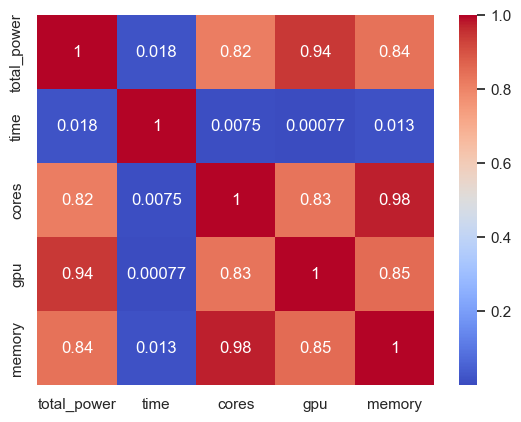

C:\Users\Nuno\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


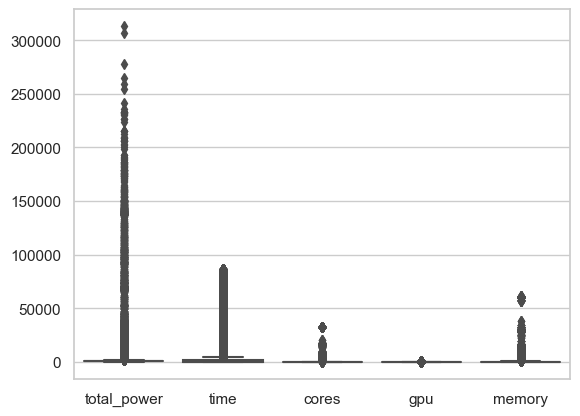

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_completed is already defined and contains the required columns
lis = df_completed["power_consumption"]
time = df_completed["run_time"]
cores = df_completed["num_cores_alloc"]
gpus = df_completed["num_gpus_alloc"]
memory = df_completed["mem_alloc"]

total_power = []

for i in range(len(lis)):
    mean = np.mean(lis.iloc[i])
    total_power.append(mean)


# Construct DataFrame with calculated and original data
all_arrays = np.column_stack([total_power, time, cores, gpus, memory])
df = pd.DataFrame(all_arrays, columns=['power', 'time', 'cores', 'gpu', 'memory'])

# Save DataFrame to Parquet file
df.to_parquet('ihl.parquet', engine='pyarrow')

# Load the Parquet file
df = pd.read_parquet('ihl.parquet', engine='pyarrow')

# Calculate and plot correlation matrix
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Plot boxplot
sns.boxplot(data=df[['power', 'time', 'cores', 'gpu', 'memory']])
plt.show()



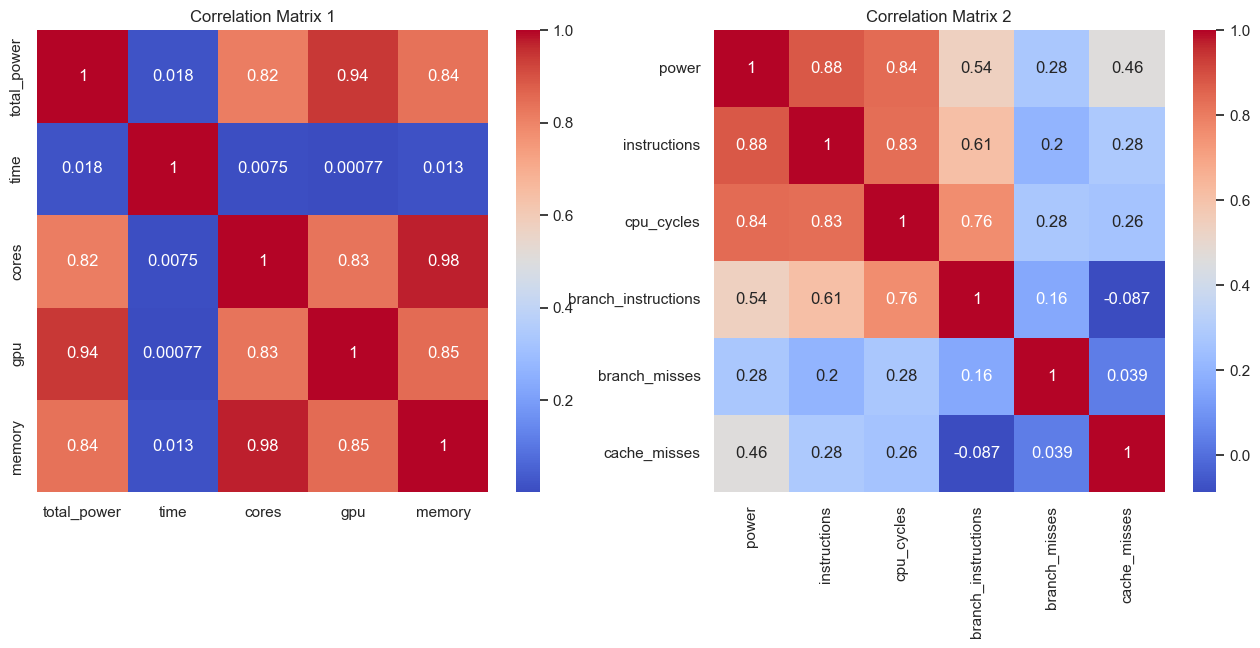

C:\Users\Nuno\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
C:\Users\Nuno\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


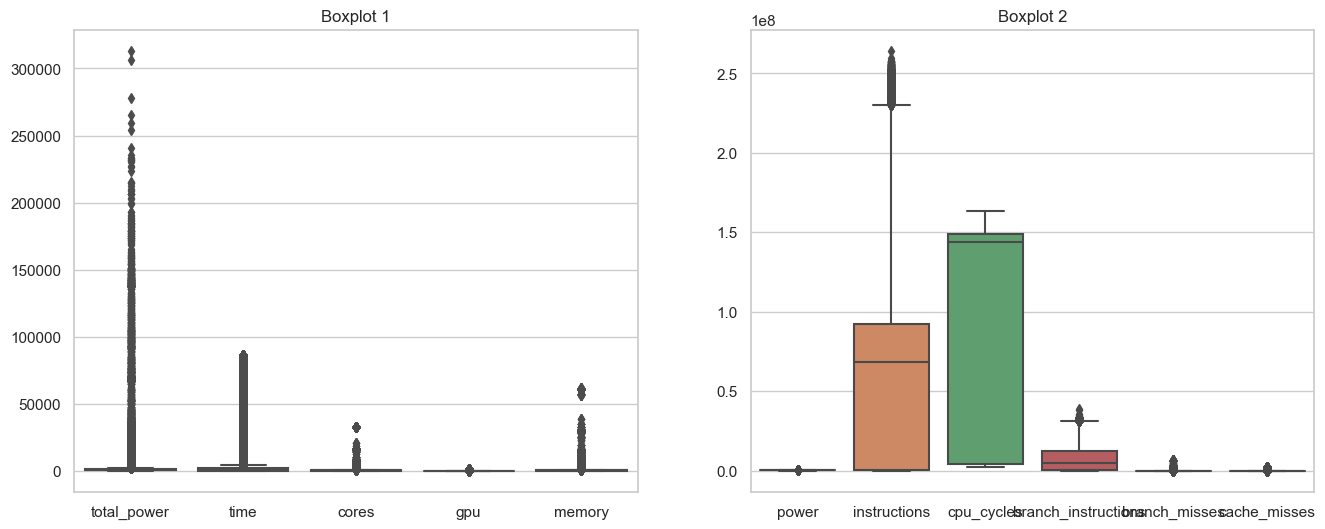

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_completed is already defined and contains the required columns
lis = df_completed["power_consumption"]
time = df_completed["run_time"]
cores = df_completed["num_cores_alloc"]
gpus = df_completed["num_gpus_alloc"]
memory = df_completed["mem_alloc"]

total_power = []

for i in range(len(lis)):
    mean = np.mean(lis.iloc[i])
    total_power.append(mean)

# Construct DataFrame with calculated and original data
all_arrays1 = np.column_stack([total_power, time, cores, gpus, memory])
df1 = pd.DataFrame(all_arrays1, columns=['total_power', 'time', 'cores', 'gpu', 'memory'])

# Save DataFrame to Parquet file
df1.to_parquet('ihl.parquet', engine='pyarrow')

# Load the Parquet file
df1 = pd.read_parquet('ihl.parquet', engine='pyarrow')

# Calculate the first correlation matrix
corr_matrix1 = df1.corr()

# Second dataset
power = np.array(power)
instructions = np.array(instructions)
cpu_cycles = np.array(cpu_cycles)
branch_instructions = np.array(branch_instructions)
branch_misses = np.array(branch_misses)
cache_misses = np.array(cache_misses)

all_arrays2 = np.column_stack([power, instructions, cpu_cycles, branch_instructions,branch_misses,cache_misses])
df2 = pd.DataFrame(all_arrays2, columns=['power', 'instructions', 'cpu_cycles', 'branch_instructions','branch_misses','cache_misses'])

# Save DataFrame to Parquet file
df2.to_parquet('igl.parquet', engine='pyarrow')

# Load the Parquet file
df2 = pd.read_parquet('igl.parquet', engine='pyarrow')

# Calculate the second correlation matrix
corr_matrix2 = df2.corr()

# Plotting both correlation matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(corr_matrix1, annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('Correlation Matrix 1')

sns.heatmap(corr_matrix2, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Correlation Matrix 2')

plt.show()

# Plotting boxplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(data=df1[['total_power', 'time', 'cores', 'gpu', 'memory']], ax=axes[0])
axes[0].set_title('Boxplot 1')

sns.boxplot(data=df2[['power', 'instructions', 'cpu_cycles', 'branch_instructions','branch_misses','cache_misses']], ax=axes[1])
axes[1].set_title('Boxplot 2')

plt.show()


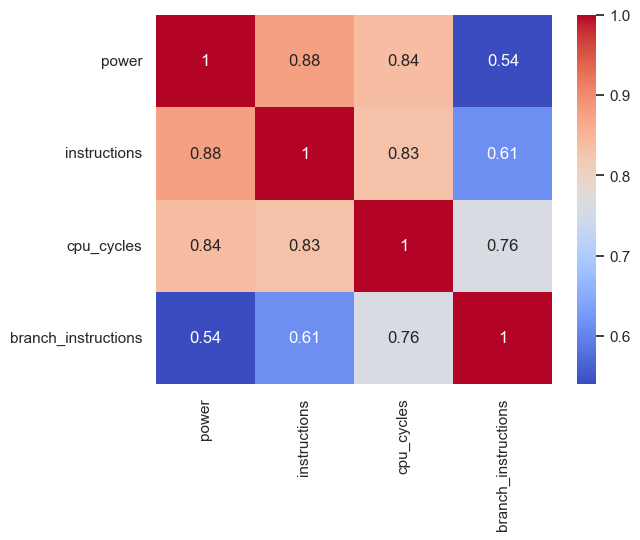

C:\Users\Nuno\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


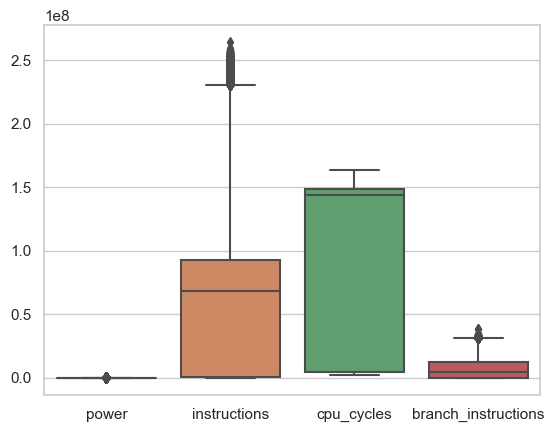

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

power = np.array(power)
##cache_misses = np.array(cache_misses)
instructions = np.array(instructions)
cpu_cycles = np.array(cpu_cycles)
branch_instructions = np.array(branch_instructions)
##branch_misses = np.array(branch_misses)

all_arrays = np.column_stack([power, instructions, cpu_cycles, branch_instructions])
df = pd.DataFrame(all_arrays, columns=['power', 'instructions', 'cpu_cycles', 'branch_instructions'])

# Save DataFrame to Parquet file
df.to_parquet('igl.parquet', engine='pyarrow')

# Load the Parquet file
df = pd.read_parquet('igl.parquet', engine='pyarrow')

# Calculate and plot correlation matrix
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Plot boxplot
sns.boxplot(data=df[['power', 'instructions', 'cpu_cycles', 'branch_instructions']])
plt.show()


In [10]:
def generate_time_kde(num_values, data, bandwidth=0.5):
    data = np.array(data)
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(data[:, None])
    
    new_samples = kde.sample(num_values)
    
    return new_samples.flatten()
def generate_time(num_values):

    time = np.array(df_completed["run_time"])

    augmented_time_data = generate_time_kde(num_values, time)
    
    return augmented_time_data
   


In [6]:
def generate_inst_kde(num_values, data, bandwidth=0.5):
    data = np.array(data)
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(data[:, None])
    
    new_samples = kde.sample(num_values)
    
    return new_samples.flatten()

def generate_instructions(num_values):
    power = pd.read_csv('C://Users/Nuno/HPC-ODA/power_prediction/responses/responses.csv', usecols=[1], header=0, names=['y'])['y'].values
    instructions = pd.read_csv('C://Users/Nuno/HPC-ODA/power_prediction/sensors/node0.instructions.csv', usecols=[1], header=0, names=['y'])['y'].values[1:-1]

    inspow = np.divide(instructions, power)
    
    augmented_inst_data = generate_inst_kde(num_values, inspow)
    
    return augmented_inst_data

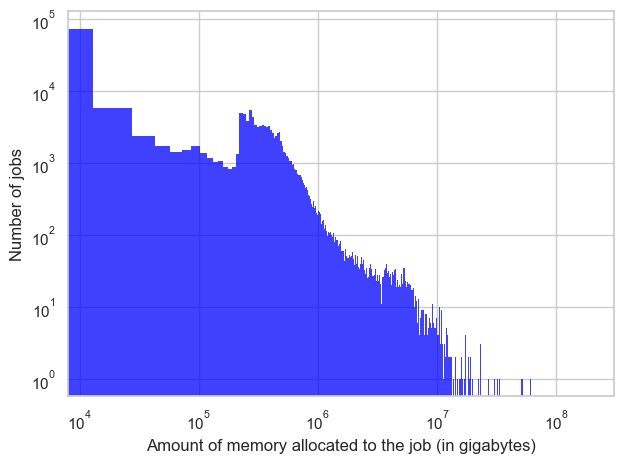

In [6]:
power = generate_power(200000)
inst1 = generate_instructions(200000)
inst = [round(inst1 [i] * power[i]) for i in range(200000)]
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.histplot(inst, kde=False, log_scale = False, color='blue')
plt.xlabel("Amount of memory allocated to the job (in gigabytes)")
plt.ylabel("Number of jobs")
plt.yscale("log")
plt.xscale("log")
plt.tight_layout()

In [7]:
def generate_bi_kde(num_values, data, bandwidth=0.5):
    data = np.array(data)
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(data[:, None])
    
    new_samples = kde.sample(num_values)
    
    return new_samples.flatten()

def generate_branch_instructions(num_values):
    power = pd.read_csv('C://Users/Nuno/HPC-ODA/power_prediction/responses/responses.csv', usecols=[1], header=0, names=['y'])['y'].values
    branch_instructions = pd.read_csv('C://Users/Nuno/HPC-ODA/power_prediction/sensors/node0.branch-instructions.csv', usecols=[1], header=0, names=['y'])['y'].values[1:-1]

    bipow = np.divide(branch_instructions, power)
    
    augmented_bi_data = generate_bi_kde(num_values, bipow)
    
    return augmented_bi_data

In [8]:
l1 = [1,2,3,4,5]
print (l1[2:])

[3, 4, 5]


In [19]:
import pandas as pd
import numpy as np
import random

# Assuming the below functions are defined elsewhere in your code:
# generate_power, generate_instructions, generate_branch_instructions, 
# generate_time, generate_memory2, generate_cores1, generate_gpus1,
# create_dict, add_label, calc_percentage, aux, fit, calc_values

def generate_values(num_values, noise, percentage=None):
    total_values = num_values
    power = generate_power(total_values)
    inst1 = generate_instructions(total_values)
    inst = [round(inst1[i] * power[i]) for i in range(num_values)]
    bipow1 = generate_branch_instructions(total_values)
    bi = [round(bipow1[i] * power[i]) for i in range(num_values)]
    time = generate_time(total_values)
    memory = generate_memory2(total_values)
    cores = generate_cores1(total_values)
    gpus = generate_gpus1(total_values)
    
    print("Generated power values:", power)
    print("Generated memory values:", memory)
    print("Generated time values:", time)
    
    nt = (noise / 100)
    ni = np.random.uniform(0.01, nt / 2)
    nbi = np.random.uniform(0.01, nt / 2)
    n = [ni, nbi, nt]
    tasks = [list(t) for t in zip(inst, bi, time)]
    matched = create_dict(tasks, n)

    print("DONE")
    if percentage is None:
        matched = add_label(matched)

        all_arrays = []
        for key, arrays in matched.items():
            for array in arrays:
                all_arrays.append(array)
        
        # Print statements for debugging before DataFrame creation
        print("Final arrays before DataFrame creation:")
        for i in range(5):  # Print first 5 for brevity
            print(all_arrays[i])

        for k1 in range(len(all_arrays)):
            split = 3
            add = [cores[k1], gpus[k1], power[k1], memory[k1]]  # Corrected the order of adding
            first = (all_arrays[k1])[:split]
            second = (all_arrays[k1])[split:]
            all_arrays[k1] = first + add + second
        
        # Print statements for debugging after arrays modification
        print("Arrays after adding cores, gpus, power, memory:")
        for i in range(5):  # Print first 5 for brevity
            print(all_arrays[i])

        random.shuffle(all_arrays)
        df = pd.DataFrame(all_arrays, columns=['inst', 'bi', 'time', 'cores', 'gpus', 'power', 'memory', "label"])
        df.to_parquet('gengen.parquet', engine='pyarrow')
        per_out = calc_percentage(matched)

    else:
        per1 = calc_percentage(matched)
        p = percentage
        if per1 > p:
            print("not gonna work")
            return

        regu = int(total_values * (percentage / 100))
        irregu = int(total_values - regu)
        dist = aux(regu, irregu)

        matched = fit(matched, dist, n)
        per_out = calc_percentage(matched)
        lent = calc_values(matched)
        matched = add_label(matched)

        all_arrays = []
        for key, arrays in matched.items():
            for array in arrays:
                all_arrays.append(array)

        for k1 in range(len(all_arrays)):
            split = 2 
            add = [cores[k1], gpus[k1], power[k1], memory[k1]]  # Corrected the order of adding
            first = (all_arrays[k1])[:split]
            second = (all_arrays[k1])[split:]
            all_arrays[k1] = first + add + second

        random.shuffle(all_arrays)
        df = pd.DataFrame(all_arrays, columns=['inst', 'bi', 'time', 'cores', 'gpus', 'power', 'memory', "label"])
        df.to_parquet('gen.parquet', engine='pyarrow')

    return per_out

# Example call to the function for debugging
print(generate_values(1000, 10))
df = pd.read_parquet('gen100.parquet', engine='pyarrow')
print(df)


Generated power values: [   807.4431466     528.39777826    637.0973352    1020.62244121
   1110.10095182    750.67970768   1270.86816636    535.04786035
    800.09941604  11994.49468476    958.17434771    549.88096735
    621.77253958    984.55874031   1039.42583011    580.08656402
    842.34655249    521.84248355    522.10380531    550.17699089
    626.89680041   3703.43336034    610.15639428    549.98081008
    889.90999344    510.13303066    621.50848627    533.25348838
    665.14672342   6217.18070862    529.90353908    538.65329112
   2615.94215464    551.96029655    559.38372888   1016.19385098
    820.55813466    799.62206079    829.75061699    750.12061692
    772.48943477    579.44394947    679.79390901    519.1820098
  57112.51727185    862.57140649   2749.67769794    960.62563791
   1398.98683601   2133.46856479    541.47591112   3940.68740539
    593.10803976    558.4581598     759.88235625    539.47323338
    514.92383322   1310.63476431    850.2887507    9517.28716958
  

In [7]:
def calc_values(matched_dic):
    lent = sum(len(matched_list) for matched_list in matched_dic.values())
    
    return lent

def calc_percentage (matched):
    total = 0
    reg = 0

    for key, value in matched.items():
        total += len(value)
        if len(value) > 1:
            reg += len(value)

    per = ((reg / total) * 100)
    
    return per

In [8]:
def create_dict(l, noise):
    check_tasks = l
    matched_dict = {}
    i = 0  # Initialize i
    n1, n2, n3 = noise  # Unpack noise values
    while i < len(check_tasks):
        matched_list = [check_tasks[i]]  # Initialize matched_list with the current index i
        value = check_tasks[i]
        indices_to_remove = []

        for j in range(i + 1, len(check_tasks)):
            if (abs(check_tasks[j][0] - value[0]) <= n1 * value[0] and
                    abs(check_tasks[j][1] - value[1]) <= n2 * value[1] and
                    abs(check_tasks[j][2] - value[2]) <= n3 * value[2]) and (i != j):
                matched_list.append(check_tasks[j])
                indices_to_remove.append(j)

        for idx in sorted(indices_to_remove, reverse=True):
            del check_tasks[idx]

        matched_dict[i] = matched_list
        i += 1

    sorted_matched_dict = {k: v for k, v in sorted(matched_dict.items(), key=lambda item: len(item[1]), reverse=True)}
    return sorted_matched_dict


In [9]:
import random
import numpy as np

def aux(regular, irregular):
    high_bound = 0.05 * regular
    if high_bound < 2 :
        high_bound = 3
    random_values = []
    
    while sum(random_values) < regular:
        random_values.append(np.random.randint(2, high_bound))
        

    if sum(random_values) > regular:
        adjustment = sum(random_values) - regular
        while adjustment > 0:        
            max_index = random_values.index(max(random_values))
            random_values[max_index] -= 1
            adjustment -= 1
    
    array_of_ones = [1] * irregular
    
    random_values.extend(array_of_ones)
    return random_values

def add_label (matched):
    i = 0
    for key in matched.keys():
        matched_list = matched[key]
        if len(matched_list) == 1:
            matched_list[0].append(0)
        elif len(matched_list) > 1:
            for i in range(len(matched_list)):
                matched_list[i].append(1)
                
    return (matched)

import numpy as np

def generate_tuples(l, noise, num, add=None):
    matched_list = l

    for i in range(num):
        lis = [0,0,0] 
        for j in range(len(lis)):
            n = noise[j]
            low_bound = matched_list[0][j] - matched_list[0][j] * n
            high_bound = matched_list[0][j] + matched_list[0][j] * n
            to_add = round(np.random.uniform(low_bound, high_bound))
            lis[j] = to_add
        matched_list.append(lis)
    
    return matched_list

def fit(l, dist, noise):
    matched_dic = l
    dist = sorted(dist, reverse=True)
    i = 0
    keys_to_change = []
    new_matched = []
    
    keys_to_delete = []
    for key in matched_dic.keys():
        matched_list = matched_dic[key]
        if i < len(dist):
            new = dist[i] - len(matched_list)
            if new > 0:
                matched_list = generate_tuples(matched_list, noise, new)

            elif new < 0:
                keys_to_change.append(key)
                matched_list = matched_list[:new]
                new_matched.append(matched_list)
            

            else :
                matched_list = matched_list

        
        elif i >= len(dist):
            keys_to_delete.append(key)
            
        
        i = i + 1
        
    j = 0
    for key in keys_to_change:
        matched_dic[key] = new_matched[j]
        j = j + 1

    for key_to_delete in keys_to_delete:
        del matched_dic[key_to_delete]
        

    return matched_dic

def fix(matched_dic, total_values, interval, noise):
    matched = matched_dic
    lent = calc_values(matched)
        
    last_keys = list(matched.keys())[interval:]
    
    if lent > total_values:
        to_remove = lent - total_values
        keys_to_remove = random.sample(last_keys, to_remove)
        
        for key in keys_to_remove:
            del matched[key]
    else:
        while lent < total_values:
            to_add = total_values-lent
            matched = find_irr(matched,to_add,noise)
            
    return (matched)


In [13]:
print(generate_values(1000,10))

[  8470.16680082    930.03913573    690.40780059    959.8621453
    542.71483876    809.49082644    921.04648749    517.92806323
    829.67559427   1273.56538986    837.28535264   1044.54456732
    881.1494956    1079.75405954    920.36288483  11624.64093618
    525.57389654    922.86878918    769.47830833   1429.70161909
   6524.84309789    533.34744276    608.33318456   1243.56850147
    610.58177299   4179.64163462    524.16024935   1248.25491001
    929.13585292  10875.69087882   7409.25769805    874.63779829
    739.55508842  12118.99890396  14292.49792163    780.2427473
    705.23288908    533.24200349    566.40933208    530.18930621
    521.01517463  11127.17065894  22419.19976345    549.77115081
    810.14265669   1368.74608555    580.52418326    580.98260788
    779.64904515    906.43686239    684.77898711   8632.66854451
   8118.80805478    850.69908237    517.1227863     596.26895549
   1150.24778508    519.41645172    539.55467363    872.6231648
   1220.494384      514.7867

[6.83893431e+00 6.61394600e+01 2.37502863e+03 8.34151922e+01
 2.24319404e+02 8.28583419e+01 1.94859632e+02 2.37242949e+02
 2.91465326e+01 1.18196729e+02 1.17736232e+02 1.17705586e+02
 2.36500976e+02 2.37240177e+02 1.16773083e+02 4.48548022e+02
 4.80933211e+02 4.60030513e+03 2.36748450e+02 2.36365674e+02
 1.17920675e+02 2.35679539e+02 5.89082975e+01 2.36908958e+02
 3.00352538e+01 2.36963394e+02 5.99753959e+01 2.36891487e+02
 1.18389248e+02 2.23660206e+02 9.19363903e+02 5.91986687e+01
 1.79066723e+02 2.02047014e+03 5.82436877e+01 2.36904008e+02
 2.39794622e+02 8.97967136e+02 2.82931908e+01 4.80393823e+02
 2.40194483e+02 2.37071630e+02 2.24298562e+02 2.40358323e+02
 3.84240171e+03 5.95349109e+01 2.36815265e+02 2.37443149e+02
 2.36200759e+02 2.89036095e+01 1.18009039e+02 2.36863365e+02
 8.27590229e+01 1.15171558e+02 3.59249096e+03 2.36304547e+02
 2.36461079e+02 2.37126484e+02 2.37210507e+02 2.92797012e+01
 4.75416963e+02 4.75275716e+02 2.37447812e+02 2.37335928e+02
 2.34331813e+02 3.841966

DONE
0.6


In [14]:
df = pd.read_parquet('gen100.parquet',engine='pyarrow')
print (df)

         inst       bi         time  cores  gpus        power       memory  \
0      461520     7622  7359.460515    128     1   838.577224    15.943726   
1        3496   127112   233.680977    256    16   586.930132  5263.342705   
2        4527   105670   236.867824    128     4   670.044723    33.886321   
3    18852970  2064963   218.518404    128     5   530.163291  3507.130366   
4        4946     2821    28.539526     64     4   909.151880  4017.382481   
..        ...      ...          ...    ...   ...          ...          ...   
995     16581    84253    82.684729    128     8   530.415243   396.097250   
996    379326    28071   236.336807     32     0   994.948892  1342.830233   
997    261592    32862   117.957519      4     3   940.431417   615.083033   
998      7696      131    59.080623   1152     3  1373.855918     0.482892   
999      5641      384   237.595933    128     5   831.827324   420.274122   

     label  
0        0  
1        0  
2        0  
3        0 

In [13]:
import pandas as pd

# Load the existing DataFrame
df = pd.read_parquet('predicted_1_gen.parquet', engine='pyarrow')

# Generate the 'power' values
num_values = len(df)
power_values = generate_power(num_values)

# Add the 'power' column to the DataFrame
df['power'] = power_values

df = df.drop(columns=['label'])

df.to_parquet('gen_with_power.parquet', engine='pyarrow', index=False)

# Print the DataFrame to verify
print(df)


          inst     bi         time  cores  gpus  memory         power
4       243103  78906    28.839636     16     4     1.0    606.908161
5       228880  74072   223.627759    128     4  3670.0   2235.095169
7       276092  89815    29.479093      4     3   424.0   1009.853342
8       238806  77543   237.161456     16     4   438.0    597.690931
9       264545  74356   118.819548    128     0  1243.0    860.369896
...        ...    ...          ...    ...   ...     ...           ...
649992  235960  78842  2021.538299     64    64    48.0    898.446236
649995  278162  77926    29.263680    128     4   367.0   2502.725387
649997  281879  91283   236.635441     64     0   453.0    539.687111
649998  231259  76857   117.031384     24     3  3266.0    804.000529
649999  229382  74911   117.941015     24     4   406.0  10904.721454

[334963 rows x 7 columns]


In [11]:
import numpy as np
from sklearn.neighbors import KernelDensity

def generate_core_kde(num_values, data, allowed_values, bandwidth=0.5):
    data = np.array(data)
    allowed_values = np.array(allowed_values)
    
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(data[:, None])
    
    new_samples = kde.sample(num_values).flatten()
    
    nearest_samples = np.array([allowed_values[np.abs(allowed_values - sample).argmin()] for sample in new_samples])
    
    return nearest_samples

def generate_cores1(num_values):
    cores = np.array(df_completed["num_cores_alloc"])
    allowed_values = np.array([4, 8, 12, 16, 20, 24, 28, 32, 36, 40,
                               44, 48, 52, 56, 60, 64, 68, 72, 76, 80,
                               84, 88, 92, 96, 100, 104, 108, 112, 116, 120,
                               124, 128, 132, 136, 140, 144, 148, 152, 160, 168,
                               176, 184, 192, 200, 208, 216, 224, 232, 240, 248,
                               256, 288, 320, 352, 384, 400, 416, 448, 480, 512,
                               576, 640, 720, 768, 832, 896, 960, 1024, 1152, 1280,
                               1408, 1536, 1600, 1664, 1792, 1920, 2048, 2176, 2304, 2560,
                               2688, 3072, 3200, 3456, 3584, 3840, 4096, 4224, 4480, 4608,
                               5120, 6016, 6144, 6400, 6656, 6912, 7168, 7680, 8192, 8320,
                               9216, 10240, 10368, 12544, 12800, 13824, 14336, 16128,
                               16384, 18432, 20736, 32256, 32768])
    
    augmented_core_data = generate_core_kde(num_values, cores, allowed_values)
    
    return augmented_core_data


In [12]:
import numpy as np
from sklearn.neighbors import KernelDensity

def generate_gpu_kde(num_values, data, allowed_values, bandwidth=0.5):
    data = np.array(data)
    allowed_values = np.array(allowed_values)
    
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(data[:, None])
    
    new_samples = kde.sample(num_values).flatten()
    
    # Map generated samples to the nearest allowed value
    nearest_samples = np.array([allowed_values[np.abs(allowed_values - sample).argmin()] for sample in new_samples])
    
    return nearest_samples

def generate_gpus1(num_values):
    gpus = np.array(df_completed["num_gpus_alloc"])
    allowed_values = np.array([0, 1, 2, 3, 4, 5, 6, 8, 12, 16, 20, 24, 28, 30, 32, 36, 40, 44, 48, 50, 
                               52, 56, 60, 64, 68, 72, 80, 88, 96, 100, 108, 112, 120, 128, 132, 140, 
                               144, 160, 188, 192, 200, 208, 216, 224, 240, 256, 260, 288, 320, 324, 
                               392, 400, 432, 448, 504, 512, 576, 648, 1008, 1024])
    
    augmented_gpu_data = generate_gpu_kde(num_values, gpus, allowed_values)
    
    return augmented_gpu_data


In [13]:
import numpy as np
from sklearn.neighbors import KernelDensity
def generate_memory_kde(num_values, data, bandwidth=0.5):
    data = np.array(data)
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(data[:, None])
    
    new_samples = kde.sample(num_values)
    
    return new_samples.flatten()
def generate_memory2(num_values):

    memory = np.array(df_completed["mem_alloc"])

    augmented_memory_data = generate_memory_kde(num_values, memory)
    
    return augmented_memory_data
   

In [ ]:
branch_misses_data = pd.read_csv('C://Users/Nuno/HPC-ODA/power_prediction/sensors/node0.branch-misses.csv', skiprows=1, usecols=[1], header=None, names=['y']) ##These are branch instructions.
cpu_cycles_data = pd.read_csv('C://Users/Nuno/HPC-ODA/power_prediction/sensors/node0.cpu-cycles.csv', skiprows=1, usecols=[1], header=None, names=['y'])
cache_misses_data = pd.read_csv('C://Users/Nuno/HPC-ODA/power_prediction/sensors/node0.cache-misses.csv', skiprows=1, usecols=[1], header=None, names=['y'])

In [ ]:
def generate_bi_kde(num_values, data, bandwidth=0.5):
    data = np.array(data)
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(data[:, None])
    
    new_samples = kde.sample(num_values)
    
    return new_samples.flatten()

def generate_branch_instructions(num_values):
    power = pd.read_csv('C://Users/Nuno/HPC-ODA/power_prediction/responses/responses.csv', usecols=[1], header=0, names=['y'])['y'].values
    branch_instructions = pd.read_csv('C://Users/Nuno/HPC-ODA/power_prediction/sensors/node0.branch-instructions.csv', usecols=[1], header=0, names=['y'])['y'].values[1:-1]

    bipow = np.divide(branch_instructions, power)
    
    augmented_bi_data = generate_bi_kde(num_values, bipow)
    
    return augmented_bi_data

In [17]:
data = generate_memory2(700000)

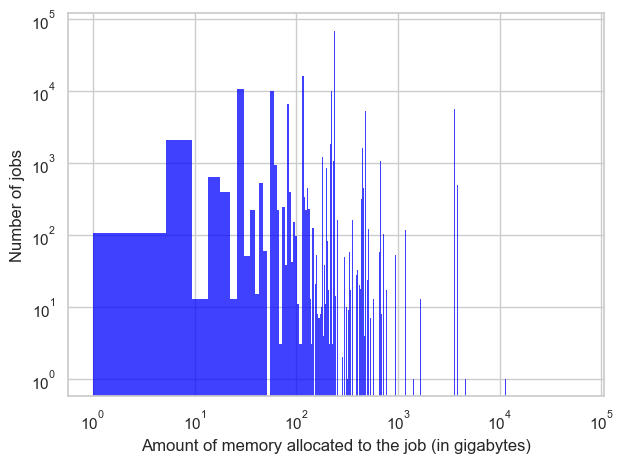

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.histplot(data=df_completed, x="mem_alloc", kde=False, log_scale = False, color='blue')
plt.xlabel("Amount of memory allocated to the job (in gigabytes)")
plt.ylabel("Number of jobs")
plt.yscale("log")
plt.xscale("log")
plt.tight_layout()

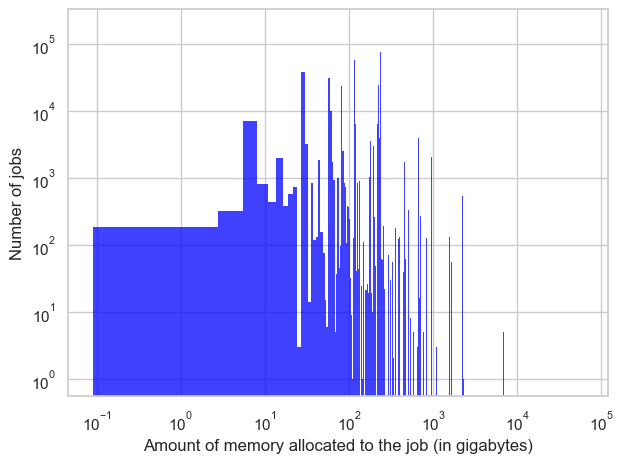

In [19]:
sns.histplot(data, kde=False, log_scale = False, color='blue')
plt.xlabel("Amount of memory allocated to the job (in gigabytes)")
plt.ylabel("Number of jobs")
plt.yscale("log")
plt.xscale("log")
plt.tight_layout()